In [1]:
#Import Libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

In [2]:
#Read and view data
data_path = ('../data/')
df = pd.read_csv(data_path+'character_predictions/character_predictions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

In [3]:
df.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


This was hard to decide which columns to drop as personally I know that in the series things such as houses and hiers, sposes, parents, and popularity all contributed to whether a person survived or not.

In [4]:
#Write wrangle function
def wrangle(filepath):
    #Read data
    df = pd.read_csv(filepath,
                     #Set index column
                    index_col='S.No')
    
    #select columns to drop
    drop_cols = df[['actual','pred', 'book1', 'book2', 'book3', 'book4', 'book5', 'isPopular']]
    
    #drop columns from data frame
    df.drop(columns=drop_cols, inplace=True)
    
    #fill age na values
    df['age'].fillna(0, inplace=True)
    
    #Change age from float to int
    df['age'].astype(int)
    
    #return datafram
    return df

#apply wrangle function
df = wrangle(data_path+'character_predictions/character_predictions.csv')

In [5]:
#Set target
target = 'isAlive'

#Creat target vector
y = df[target]

#Create feature matrix
X = df.drop(columns=target)

#Check shape
print('The shape of y is:', y.shape)
print('The shape of X is:', X.shape)

The shape of y is: (1946,)
The shape of X is: (1946, 23)


In [6]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

Even though our majority class is imbalanced we should still set a baseline score and we will use other evaluations as well

In [7]:
#Establish baseline accuracy
print('Baseline accuracy score:',y_train.value_counts(normalize=True).max())

Baseline accuracy score: 0.7429305912596401


This is just a quick model to satisfy the assignment requirements and not the final model I plan on using.

In [8]:
#Build model
model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=26, n_jobs=-2)
)

#Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'title', 'culture', 'mother',
                                      'father', 'heir', 'house', 'spouse'],
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Ulf the Ill           1
Mathis Frey           2
Torbert               3
Ulf son of Umar       4
Ned (ferryman)        5
                   ... 
Zia Frey           1553
Tywin Lannister    1554
Ryger Rivers       1555
Old Henly          1556
NaN                  -2
Length: 1557, dtype: int64},
                                         {'col': 'title',
                                          'data_type'...
Length: 309, dtype: int64},
                                         {'col': 'spouse',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                  

In [9]:
#Check metrics
print('Train set accuracy:', model.score(X_train, y_train))
print('Validation set accuracy:', model.score(X_val, y_val))

Train set accuracy: 1.0
Validation set accuracy: 0.9


In [10]:
#Get permutated importances
permutated = permutation_importance(model, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-2, 
                                 random_state=26 )
#Train model on top 5 importances
cols_drop = X_val.columns

X_train_top_5 = X_train[pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(5).index]
X_val_top_5 =  X_val[pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(5).index]

permutated_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=26, n_jobs=-2)
)

permutated_model.fit(X_train_top_5, y_train)
print('Permutated Validation set accuracy', permutated_model.score(X_val_top_5, y_val))

Permutated Validation set accuracy 0.8897435897435897


Text(0, 0.5, 'feature name')

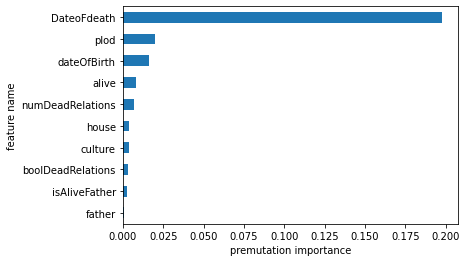

In [11]:
#Visualize what the top importances are
pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(10).plot(kind='barh')
plt.xlabel('premutation importance')
plt.ylabel('feature name')

In [12]:
#Use xgboost to create new model
xgb_model = make_pipeline(OrdinalEncoder(),
                         XGBClassifier(n_estimators=100,
                                      max_depth=20,
                                      learning_rate=1e-3,
                                      n_jobs=-2))

#Fit model
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'title', 'culture', 'mother',
                                      'father', 'heir', 'house', 'spouse'],
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Ulf the Ill           1
Mathis Frey           2
Torbert               3
Ulf son of Umar       4
Ned (ferryman)        5
                   ... 
Zia Frey           1553
Tywin Lannister    1554
Ryger Rivers       1555
Old Henly          1556
NaN                  -2
Length: 1557, dtype: int64},
                                         {'col': 'title',
                                          'data_type'...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                      

In [13]:
#Check metric of new model
print('XGBoost Training set accuracy',xgb_model.score(X_train, y_train))
print('XGBoost Validation set accuracy',xgb_model.score(X_val, y_val))

XGBoost Training set accuracy 0.9967866323907455
XGBoost Validation set accuracy 0.9871794871794872


In [14]:
#Make partial dependency plot to see how a feature is related to the target for prediction model
#Retrain model to create partial dependency plot
encoder = OrdinalEncoder()
X_train_T = encoder.fit_transform(X_train)
X_val_T = encoder.transform(X_val)
pdp_model = XGBClassifier(n_estimators=200, n_jobs=-2)

#Fit model
pdp_model.fit(X_train_T, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

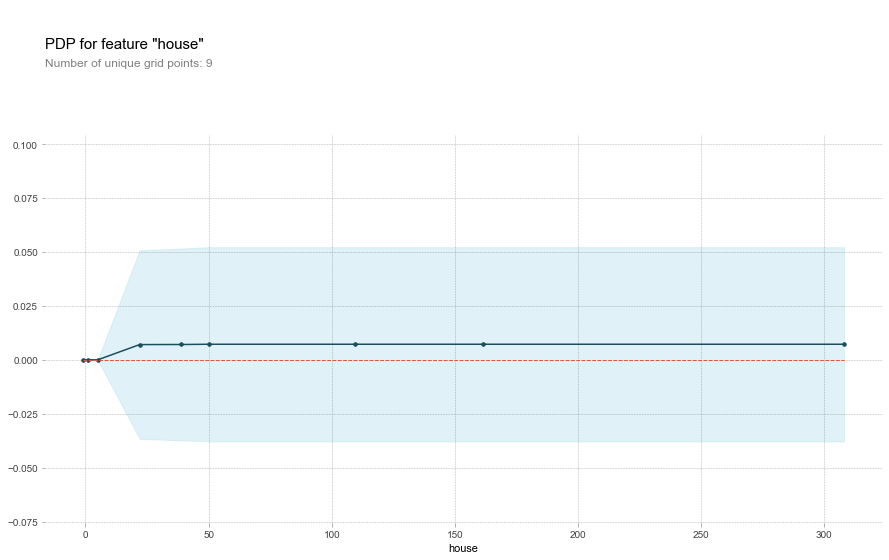

In [22]:
#Select feature to observe
feature = 'house'

#Create plot
isolated = pdp_isolate(model=pdp_model, dataset=X_val_T, model_features=X_val_T.columns, feature=feature)
pdp_plot(isolated, feature);

plt.savefig('isolated.jpg')

In [ ]:
#make shap model to see specifically how the feature affects the prediction
#Select single observation to view and transform it
row = X_val.iloc[[1]]
row = encoder.transform(row)

#predict
pdp_model.predict(row)

explainer = shap.TreeExplainer(pdp_model) 
shap_values = explainer.shap_values(row)
shap_values 

shap.initjs()
shap.force_plot(
                base_value=explainer.expected_value,
                shap_values=shap_values,
                features=row)